# Analyse dynamique des déterminants des prix immobiliers et de l'impact des taux d'intérêt sur le marché du logement

**Projet Python - 2A ENSAE**

## Introduction

Notre projet vise à étudier l'influence des taux d'intérêt sur les prix immobiliers au niveau local, en prenant en compte les caractéristiques spécifiques de chaque commune telles que la densité de population, le niveau de revenus, le chômage, le taux de criminalité... L'objectif principal est donc d'analyser les déterminants dynamiques des prix immobilier au niveau communal et d'étudier l'impact des taux d'intérêt sur le marché immobilier en utilisant des méthodes économétriques. Cela implique notamment l'exploration de données de séries temporelles et de panel pour fournir une compréhension complète.

Notre étude porte sur les années 2014 à 2023 pour prendre en compte au maximum les variations des taux d'intérêt. Pour réaliser notre étude, nous nous sommes notamment appuyés sur le jeu de données "Demandes de Valeurs Foncières" disponible sur data.gouv.fr (https://www.data.gouv.fr/en/datasets/demandes-de-valeurs-foncieres/) qui liste les transactions immobilières intervenues au cours des dernières années sur le territoire métropolitain et les DOM-TOM. 

Le projet se décompose en plusieurs étapes : 
1. Récupération des données

2. Agrégation

3. Visualisation de données

4. Création des variables de contrôle

5. Modélisation

## Les importations 

In [2]:
import pandas as pd
import numpy as np
import pyarrow.feather as feather
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
# Change path as needed
path = "C:/Users/lujul/interestnpy"

## I. Récupération des données

### I.1. Création de la table de passage 

La géographie des communes en France a changé entre 2014 et 2023. Nous avons donc dû construire une table de passage pour prendre en compte ce problème.

In [4]:
#IMPORTS AND FILTER INSEE TRANSLATION TABLE
PASSAGE1423_DF = pd.read_excel(path+"/data/external/GEOCOM/table_passage_annuelle_2023.xlsx", 
                               sheet_name="COM", skiprows=5)
PASSAGE1423_DF = PASSAGE1423_DF.filter(regex='^CODGEO').iloc[:, :10]
PASSAGE1423_DF = PASSAGE1423_DF[PASSAGE1423_DF['CODGEO_2023'].notna()]

In [5]:
#IMPORTS 2023 EPCI DEFINITIONS
FCOM_DF = pd.read_excel(path+"/data/external/GEOCOM/ZE2020_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

EPC_COM = pd.read_excel(path+"/data/external/GEOCOM/Intercommunalite_Metropole_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

FCOM_DF = pd.merge(FCOM_DF, EPC_COM, how='left', on=['CODGEO','LIBGEO', 'DEP', 'REG'])

In [6]:
#CREATES COM BASED ON 2023 TOWN CODES AND ZE BASED ON EPCI
FCOM_DF['COM'] = FCOM_DF['CODGEO']
FCOM_DF['LIB_COM'] = FCOM_DF['LIBGEO']
FCOM_DF['ZE'] = FCOM_DF['ZE2020']
FCOM_DF['LIB_ZE'] = FCOM_DF['LIBZE2020']
FCOM_DF['EPCI'] = FCOM_DF['ZE2020']
FCOM_DF['LIB_ZE'] = FCOM_DF['LIBZE2020']
FCOM_DF['EPCI'] = FCOM_DF.apply(
    lambda row: row['CODGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['EPCI'],
    axis=1
)
FCOM_DF['LIB_EPCI'] = FCOM_DF.apply(
    lambda row: row['LIBGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['LIBEPCI'],
    axis=1
)
FCOM_DF['LIB_EPCI'] = FCOM_DF.apply(
    lambda row: "Iles-FR" if row['EPCI'] == "ZZZZZZZZZ" else row['LIB_EPCI'],
    axis=1
)
FCOM_DF.rename(columns={'CODGEO': 'CODGEO_2023'}, inplace=True)
FCOM_DF = FCOM_DF[['CODGEO_2023', 'COM', 'LIB_COM', 'ZE', 'LIB_ZE', 'EPCI', 'LIB_EPCI']]

In [7]:
#MERGES WITH INSEE TABLE TO CREATE THE TRANSLATION TABLE 
IDENT1423_DF = pd.merge(PASSAGE1423_DF, FCOM_DF, how='left', on='CODGEO_2023')

In [8]:
#FIXES PROBLEMS RELATED TO CITIES WITH "ARRONDISSEMENTS"
conditions_arr = [
    IDENT1423_DF['CODGEO_2023'].str.startswith("75"),
    IDENT1423_DF['CODGEO_2023'].str.startswith("132"),
    IDENT1423_DF['CODGEO_2023'].str.startswith("6938")
]

ze_arr = [1109, 9312, 8421]
lib_arr = ["Paris", "Marseille", "Lyon"]

IDENT1423_DF['COM'] = IDENT1423_DF.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['COM']) else row['COM'],
    axis=1
)

IDENT1423_DF['EPCI'] = IDENT1423_DF.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['EPCI']) else row['EPCI'],
    axis=1
)
IDENT1423_DF['EPCI'] = IDENT1423_DF['EPCI'].astype(str)

IDENT1423_DF['ZE'] = np.select(
  conditions_arr, 
  ze_arr, 
  default=IDENT1423_DF['ZE'])

In [9]:
def create_lib_ident(row, col_name):
    if pd.isna(row[col_name]):
        if row['COM'][:2] == "75":
            return f"Paris {row['COM'][3:5]}"
        elif row['COM'][:2] == "69":
            return f"Lyon {int(row['CODGEO_2019']) - 80}"
        elif row['COM'][:2] == "13":
            return f"Marseille {row['COM'][3:5]}"
    else:
        return row[col_name]

In [10]:
IDENT1423_DF['LIB_COM'] = IDENT1423_DF.apply(create_lib_ident, col_name='LIB_COM', axis=1)

IDENT1423_DF['LIB_EPCI'] = IDENT1423_DF.apply(
    lambda row: row['LIB_COM'] if pd.isna(row['LIB_EPCI']) else row['LIB_EPCI'],
    axis=1
) 

IDENT1423_DF['LIB_ZE'] = np.select(
  conditions_arr, 
  lib_arr, 
  default=IDENT1423_DF['LIB_ZE'])

In [11]:
#REORDERS AND EXPORTS THE TRANSLATION TABLE
reord_cols = ['COM', 'ZE', 'LIB_COM', 'LIB_ZE', 'EPCI', 'LIB_EPCI']
IDENT1423_DF = IDENT1423_DF[reord_cols + [col for col in IDENT1423_DF.columns if col not in reord_cols]]
IDENT1423_DF.to_feather(path+"/data/interim/tble_de_passage_py.feather")

In [12]:
IDENT1423_DF.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO_2023,CODGEO_2022,CODGEO_2021,CODGEO_2020,CODGEO_2019,CODGEO_2018,CODGEO_2017,CODGEO_2016,CODGEO_2015,CODGEO_2014
0,13201,9312.0,Marseille 01,Marseille,13201,Marseille 01,13201,13201,13201,13201,13201,13201,13201,13201,13201,13201
1,13202,9312.0,Marseille 02,Marseille,13202,Marseille 02,13202,13202,13202,13202,13202,13202,13202,13202,13202,13202
2,13203,9312.0,Marseille 03,Marseille,13203,Marseille 03,13203,13203,13203,13203,13203,13203,13203,13203,13203,13203
3,13204,9312.0,Marseille 04,Marseille,13204,Marseille 04,13204,13204,13204,13204,13204,13204,13204,13204,13204,13204
4,13205,9312.0,Marseille 05,Marseille,13205,Marseille 05,13205,13205,13205,13205,13205,13205,13205,13205,13205,13205


### I.2. Prix des terrains par département

Nous utilisons des données du Ministère de la Transition écologique sur les prix des terrains par région de 2008 à 2022 afin de soustraire les prix des terrains des montants des transactions dans les données DVF.

In [13]:
#LOADS CONVERSION TABLE REG - DEP
DEPREG_DF = pd.read_excel(path+"/data/external/GEOCOM/table-appartenance-geo-communes-19.xls", 
                          sheet_name="COM", skiprows=5)[['DEP', 'REG']].drop_duplicates()
DEPREG_DF['REG'] = DEPREG_DF['REG'].astype(str)

#LOADS REGIONAL PRICES FOR LAND
TER_DF = pd.read_csv(path+"/data/external/TER/1-Terrains-achetes-nombre-surface-et-prix-moyen-par-region.2022-01.csv", 
                     delimiter=";", skiprows=1, escapechar='\\', skipinitialspace=True)

In [14]:
#CREATING ADDITIONAL CONSTANT VALUES FOR 2023
additional_rows_2023 = TER_DF[TER_DF['ANNEE'] == 2022].copy()
additional_rows_2023['ANNEE'] = 2023
TER_DF = pd.concat([TER_DF, additional_rows_2023]).sort_values('ANNEE')
TER_DF = TER_DF[TER_DF['ANNEE'] > 2013]

In [15]:
#MERGES TO GO FROM REGIONAL LEVEL TO DEPARTMENT LEVEL AND EXPORTS
TERDEP_DF = pd.merge(DEPREG_DF, TER_DF, left_on='REG', right_on='ZONE_CODE', how='left')
TERDEP_DF = TERDEP_DF.dropna().reset_index(drop=True)[['ANNEE', 'DEP', 'PTM2_MED']]
TERDEP_DF.to_feather(path+"/data/interim/terrains_py.feather")

In [16]:
TERDEP_DF.head()

,ANNEE,DEP,PTM2_MED
0,2014.0,01,105.0
1,2015.0,01,100.0
2,2016.0,01,100.0
3,2017.0,01,103.0
4,2018.0,01,106.0


### I.3. Inflation - Taux d'intérêt

In [17]:
#INFLATION TABLE
inflation = pd.read_excel(path+"/data/external/INFLATION/econ-gen-taux-inflation.xlsx", 
                          sheet_name="Données", skiprows=3, nrows=9)
inflation.rename(columns={"Année": "AN", "Taux d'inflation": "INFLATION"}, inplace=True)
inflation['AN'] = inflation['AN'].astype(str)
inflation = inflation._append({'AN': str(2023), 'INFLATION': 2.3}, ignore_index=True)
#Why 2.3? first 3 months inflation
#either way it does not matter as we will work in basis 2023
inflation.sort_values(by="AN", inplace=True)
inflation['Date'] = inflation['AN']+"0101"
inflation.loc[len(inflation)] = ["2023",0, "20230401"]
inflation['TOT'] = (1 + inflation['INFLATION'].shift(1) / 100).cumprod()
inflation['TOT'] = inflation['TOT'].fillna(1)

In [18]:
# INTEREST RATES TABLE
interest_rates = pd.read_excel(path+"/data/external/INFLATION/series_panorama_202309.xlsx", 
                               sheet_name="G3", 
                               skiprows=6, 
                               names=["Date", "ir", "ir10_avg", "ir20_avg"])

interest_rates = interest_rates[interest_rates['Date'] > '2013-12-31']

interest_rates['quarter'] = interest_rates['Date'].dt.to_period('Q').astype(str)
interest_rates = interest_rates.groupby('quarter').agg({'ir': 'mean'}).reset_index()

In [19]:
def get_month_from_quarter(quarter):
    quarter_num = quarter.split("Q")[1]
    return {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter_num, None)

In [20]:
interest_rates['themonth'] = interest_rates['quarter'].apply(get_month_from_quarter)
interest_rates['Date'] = (interest_rates['quarter'].str[:4] + interest_rates['themonth'] + "01")
interest_rates = interest_rates[['Date', 'ir']]

In [21]:
# Combine inflation and interest rates
irflation = pd.merge(interest_rates, inflation, on='Date', how='left')
irflation = irflation.interpolate(method="slinear", fill_value="extrapolate", limit_direction="both")
irflation['BASE14'] = irflation['TOT'] / irflation['TOT'].iloc[0]
irflation['BASE23'] = irflation['BASE14'] / irflation['BASE14'].iloc[37]
irflation.to_feather(path+"/data/interim/irflation.feather")

In [22]:
irflation.head()

,Date,ir,AN,INFLATION,TOT,BASE14,BASE23
0,20140101,3.183333,2014,0.500,1.00000,1.00000,0.869350
1,20140401,3.083333,NaN,0.375,1.00125,1.00125,0.870437
2,20140701,2.883333,NaN,0.250,1.00250,1.00250,0.871524
3,20141001,2.683333,NaN,0.125,1.00375,1.00375,0.872610
4,20150101,2.506667,2015,0.000,1.00500,1.00500,0.873697


# II. Agrégation

Dans cette partie, on agrège les données DVF trimestriellement en utilisant une fonction personnalisée à trois niveaux distincts : la ville, le groupe de villes et la zone d'emploi. Les données ont été filtrées et, après l'agrégation à chaque niveau, trois variables d'intérêt ont été conservées : le nombre de transactions, le prix médian et la part des maisons dans le total des transactions. Cette proportion est utilisée pour contrôler les changements structurels survenant dans les marchés immobiliers locaux, car les maisons sont souvent moins chères par mètre carré que les appartements.

In [32]:
TERDEP_DF = pd.read_feather(path+"/data/interim/terrains_py.feather")
IDENT_DF = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather").drop_duplicates()

In [ ]:
def aggreg_fun(data, ID, LIB_ID):
    quantiles = data.groupby([ID, LIB_ID, 'Date', 'Type local'])['prixM2'].quantile([0.05, 0.95]).unstack()
    quantiles.columns = ['quantile_05', 'quantile_95']
    data = data.merge(quantiles, left_on=[ID, LIB_ID, 'Date', 'Type local'], right_index=True)
    filtered_data = data[(data['prixM2'] <= data['quantile_95']) & (data['prixM2'] >= data['quantile_05'])]
    print("filtered!")
    data_agreg = filtered_data.groupby([ID, LIB_ID,'Date']).agg(
     n_transactions=('prixM2', 'size'),
     prop_maison=('Type local', lambda x: np.mean(x == 'Maison')),
    prixM2=('prixM2', 'median')
    ).reset_index()
    return data_agreg

In [ ]:
def immo_prices(year):
    # Read data
    df = pd.read_csv(path+f"/data/external/DFV/valeursfoncieres-{year}.txt", delimiter="|", dtype=str)
    df = df.dropna(axis=1, how='all')  
    # Filter and mutate
    df = df[df['Nature mutation'] == "Vente"]
    df = df[df['Code type local'].isin(['1', '2'])]
    df = df[~df['Code departement'].isin(['971', '972', '973', '974'])]
    df['Code commune'] = df['Code commune'].str.pad(width=3, side='left', fillchar='0')
    df['depcom'] = df['Code departement'] + df['Code commune']
    df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(",", ".").astype(float)
    print("ok-1")
    # Quarter and date manipulation
    df['quarter_num'] = df['Date mutation'].str[3:5].astype(int)
    df['qmonth'] = np.select([df['quarter_num'].isin(range(1, 4)), df['quarter_num'].isin(range(4, 7)), df['quarter_num'].isin(range(7, 10)), df['quarter_num'].isin(range(10, 13))], ["01", "04", "07", "10"], default=np.nan)
    df['Date'] = (str(year) + df['qmonth'] + "01")
    print("ok-2")
    # Merging with IDENT_YEAR_DF
    IDENT_YEAR_DF = IDENT_DF[['COM', 'EPCI', 'ZE', 'LIB_COM', 'LIB_EPCI', 'LIB_ZE', f'CODGEO_{year}']].drop_duplicates()
    df = df.merge(IDENT_YEAR_DF, left_on='depcom', right_on=f'CODGEO_{year}', how='left')
    print("ok-3")
    # Merging with TERDEP_DF
    df = df.merge(TERDEP_DF[TERDEP_DF['ANNEE'] == int(year)], left_on='Code departement', right_on='DEP', how='left')
    print("ok-4")
    # Calculating prixM2
    df['Surface terrain'] = df['Surface terrain'].replace(np.nan, 0).astype(float)
    df['prixM2'] = (df['Valeur fonciere'] - df['Surface terrain'] * df['PTM2_MED']) / df['Surface reelle bati'].astype(float)
    df = df[(df['prixM2'] > 10) & (df['prixM2'] < 100000)].drop_duplicates()
    print("ok-5")
    df = df.drop_duplicates(subset=['Date mutation', 'No voie', 'Valeur fonciere', 'Surface terrain', 'LIB_COM'])
    df4_epci = aggreg_fun(df,"EPCI","LIB_EPCI")
    print("ok-6")
    df4_com = aggreg_fun(df,"COM", "LIB_COM")
    print("ok-7")
    df4_ze = aggreg_fun(df,"ZE","LIB_ZE")
    print("ok-8")
    df4_full = df.groupby('Date', as_index=False).agg(prixM2=('prixM2', 'mean'))


    return [df4_com, df4_epci, df4_ze, df4_full]

In [ ]:
years = ["2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015", "2014"]
results = []

for i in years:
  results.append(immo_prices(i))

In [ ]:
# Merging results
IMMO1423_COM = pd.concat([result[0] for result in results])
IMMO1423_EPCI = pd.concat([result[1] for result in results])
IMMO1423_ZE = pd.concat([result[2] for result in results])
IMMO1423_FULL = pd.concat([result[3] for result in results])

In [ ]:
# Writing output
feather.write_feather(IMMO1423_COM, path+"/data/interim/immo_panel_com_py.feather")
feather.write_feather(IMMO1423_EPCI, path+"/data/interim/immo_panel_epci_py.feather")
feather.write_feather(IMMO1423_ZE, path+"/data/interim/immo_panel_ze_py.feather")
feather.write_feather(IMMO1423_FULL, path+"/data/interim/immo_panel_full_py.feather")

## III. Visualisation de données

In [3]:
# Reading the data
ze_shp = gpd.read_file(path+"/data/external/ze2020_2023/ze2020_2023.shp")
immo_panel = pd.read_feather(path+"/data/interim/immo_panel_ze_py.feather")
immo_panel_com = pd.read_feather(path+"/data/interim/immo_panel_com_py.feather")
immo_panel_full = pd.read_feather(path+"/data/interim/immo_panel_full_py.feather")
inflation = pd.read_feather(path+"/data/interim/inflation.feather")
interest_rates = pd.read_feather(path+"/data/interim/interest_rates.feather")

In [4]:
# Data manipulation
immo_panel = immo_panel[(immo_panel['Date'] == '20230101') | 
                           (immo_panel['Date'] == '20190101') | 
                           (immo_panel['Date'].isna())]
immo_panel.sort_values(by=['ZE', 'Date'], inplace=True)
immo_panel['dprix'] = immo_panel.groupby('ZE')['prixM2'].transform(lambda x: x - x.shift())

ze_shp['ZE'] = ze_shp['ze2020'].astype(float)
full_map = ze_shp.merge(immo_panel, on="ZE", how="left")

In [7]:
# Plotting
def plot_map(data, variable, title, palette):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.plot(column=variable, ax=ax, legend=True, cmap=palette,
    missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    plt.title(title)
    plt.xlim(-4.5, 9.5)
    plt.ylim(41.5, 51)
    ax.set_axis_off()
    plt.show()

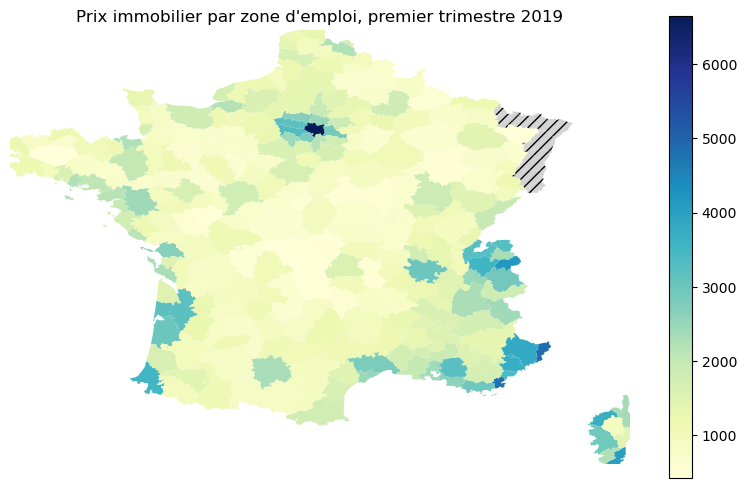

In [8]:
plot_map(full_map[(full_map['Date'] == '20190101')|(full_map['Date'].isna())], 
         'prixM2', "Prix immobilier par zone d'emploi, premier trimestre 2019", 
         "YlGnBu")

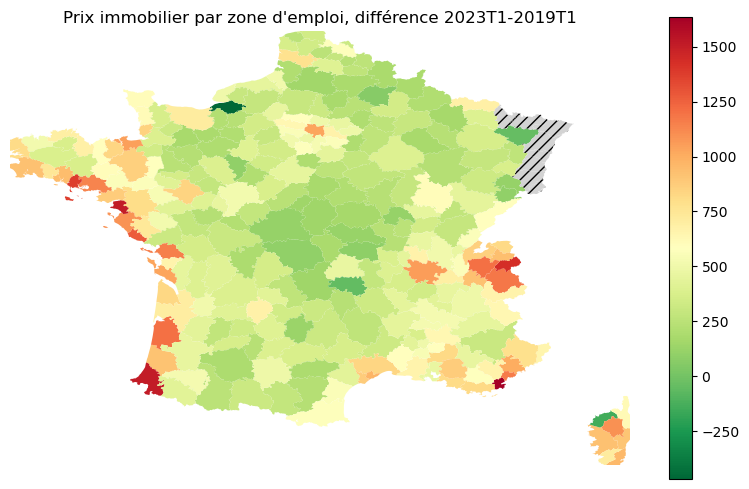

In [9]:
plot_map(full_map[(full_map['Date'] == '20230101')|(full_map['Date'].isna())], 
         'dprix', "Prix immobilier par zone d'emploi, différence 2023T1-2019T1", 
         "RdYlGn_r")

In [10]:
# Plotting time series
def plot_time_series(data, x, y, title, hue=None):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, hue=hue)
    plt.title(title)
    plt.show()

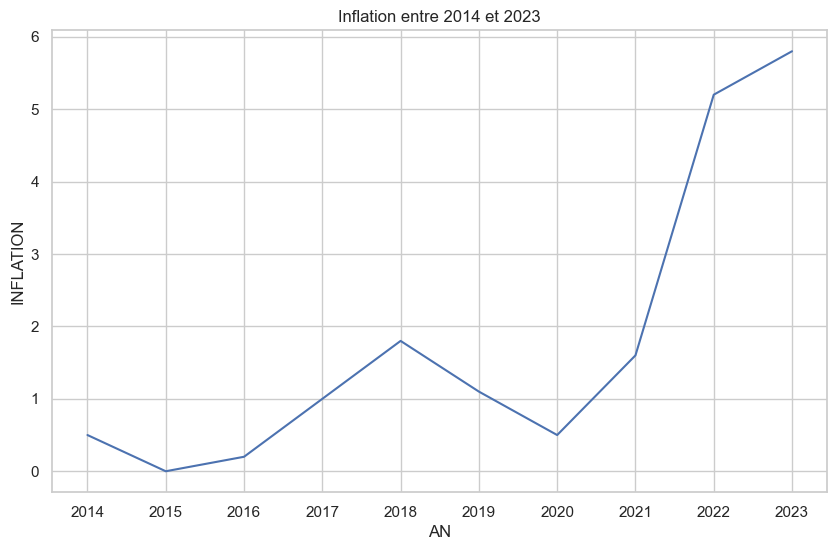

In [11]:
plot_time_series(inflation, "AN", "INFLATION", "Inflation entre 2014 et 2023")

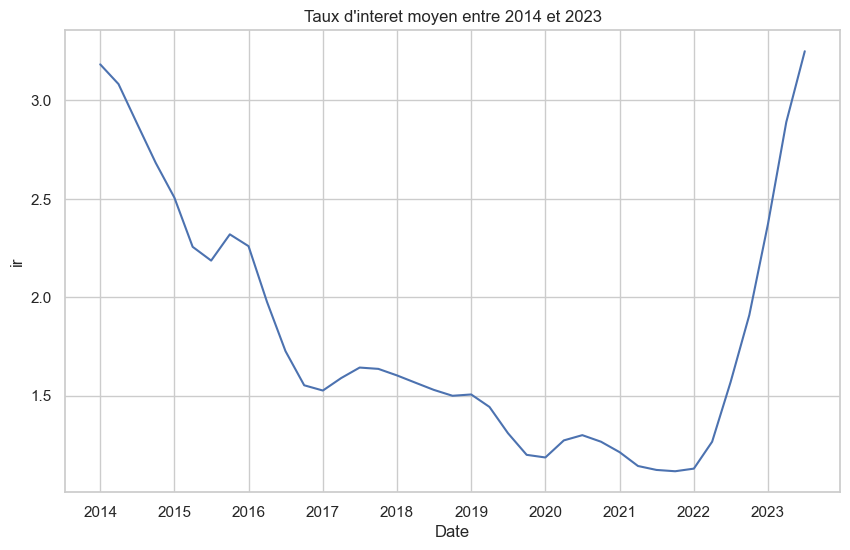

In [12]:
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'], format='%Y%m%d')
plot_time_series(interest_rates, "Date", "ir", "Taux d'interet moyen entre 2014 et 2023")

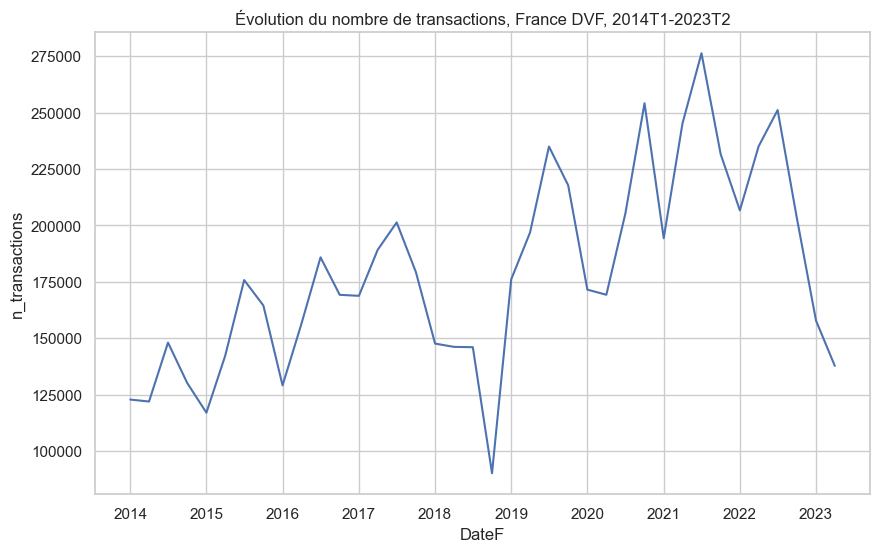

In [13]:
immo_panel_com['DateF'] = pd.to_datetime(immo_panel_com['Date'], format='%Y%m%d')
immo_panel_com_grouped = immo_panel_com.groupby('DateF').agg({'n_transactions': 'sum'}).reset_index()
plot_time_series(immo_panel_com_grouped, 'DateF', 'n_transactions', 
                 "Évolution du nombre de transactions, France DVF, 2014T1-2023T2")

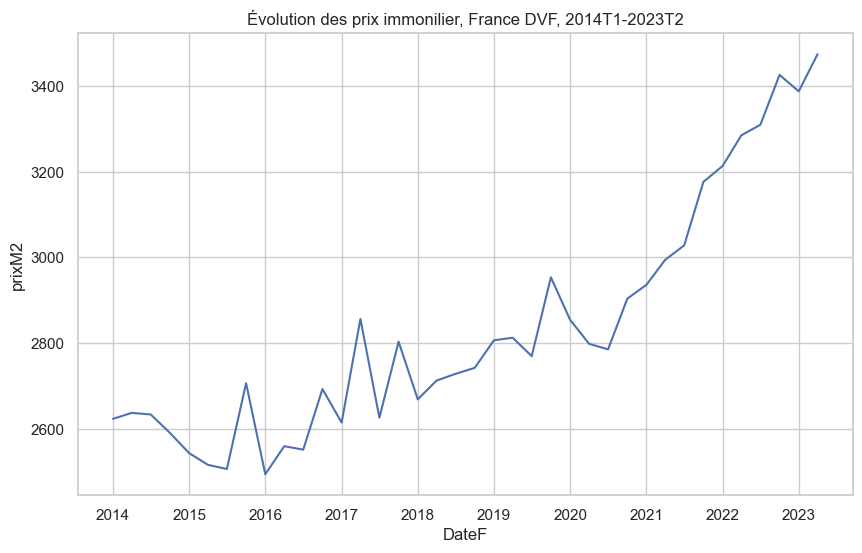

In [14]:
immo_panel_full['DateF'] = pd.to_datetime(immo_panel_full['Date'], format='%Y%m%d')
plot_time_series(immo_panel_full, 'DateF', 'prixM2', 
                 "Évolution des prix immonilier, France DVF, 2014T1-2023T2")

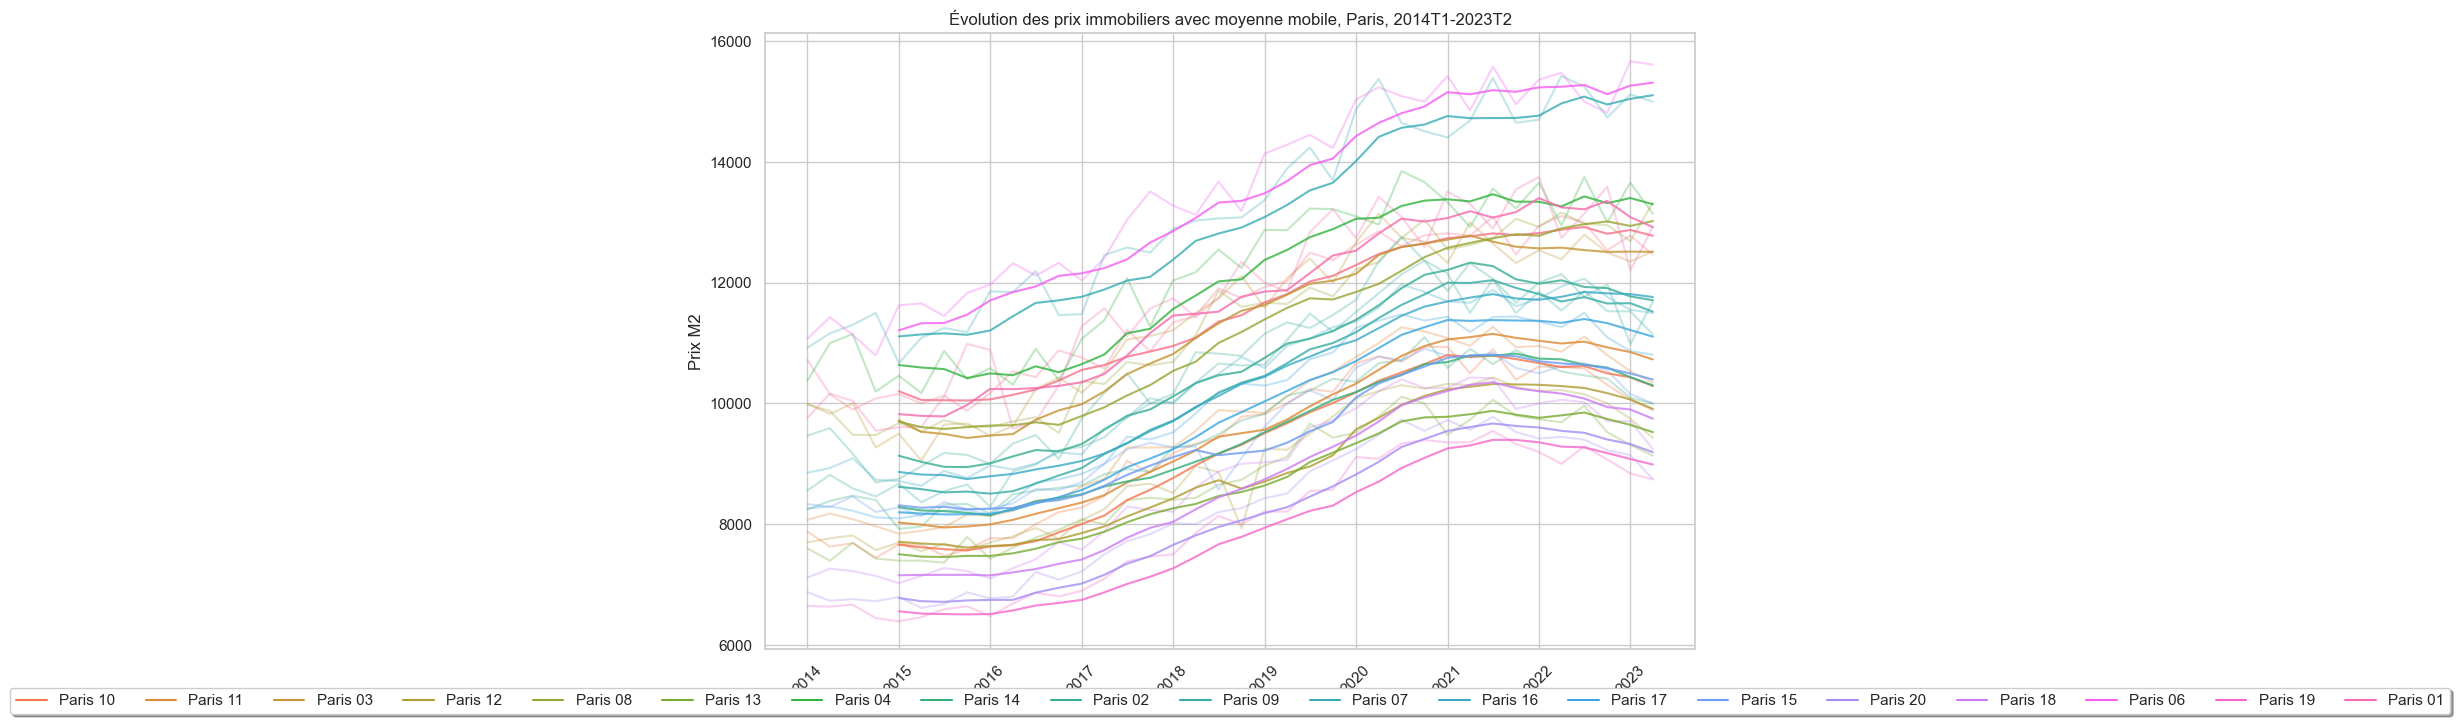

In [15]:
# Evolution des prix parisiens ---
paris_data = immo_panel_com[immo_panel_com['LIB_COM'].str.startswith('Paris ')]
paris_data = paris_data.sort_values(by='DateF')
window_size = 5  
paris_data['Moving_Average'] = paris_data.groupby('LIB_COM')['prixM2'].transform(lambda x: x.rolling(window=window_size).mean())
plt.figure(figsize=(12, 8))
sns.lineplot(data=paris_data, x='DateF', y='prixM2', hue='LIB_COM', alpha=0.3)
sns.lineplot(data=paris_data, x='DateF', y='Moving_Average', hue='LIB_COM', alpha=0.8, legend=None)
plt.title('Évolution des prix immobiliers avec moyenne mobile, Paris, 2014T1-2023T2')
plt.xlabel('Date')
plt.ylabel('Prix M2')
plt.xticks(rotation=45)
sns.set_theme(style="whitegrid")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=len(paris_data['LIB_COM'].unique()))
plt.show()

## IV. Creation des variables de contrôle